# Assignment 2

## Guidelines

> Remember that this is a code notebook - add an explanation of what you do using text boxes and markdown, and comment your code. Answers without explanations may get less points.
>
> If you re-use a substantial portion of code you find online, e.g on Stackoverflow, you need to add a link to it and make the borrowing explicit. The same applies of you take it and modify it, even substantially. There is nothing bad in doing that, providing you are acknowledging it and make it clear you know what you're doing.
>
> The **Generative AI policy** from the syllabus for the programming assignments applies. Generative AI can be used as a source of information in these assignments if properly referenced. You can use generative AI assistance for writing code, but you must reference the chat used as a source, just as if you would take from StackOverflow. In ChatGPT, you can make an URL to the information you obtained by clicking the "Share link to Chat" button and then "Copy Link". This allows you to cite the source of the information you use in your answer or code solution. Of course, as you know, GenAI tools are not always a reliable source and its answers are intransparantly drawn from other sources - it is recommended to cross-check its output with other sources or your own understanding of the topic.
> 
> For the explanations of what you do that you provide with each question, as well as for (sub)questions that ask about things like motivation of choices or your opinion, the answer to this must be conceptualized and written by yourself and not copied from a generative AI source.
>
> Make sure your notebooks have been run when you submit, as I won't run them myself. Submit both the `.ipynb` file along with an `.html` export of the same. Submit all necessary auxilliary files as well. Please compress your submission into a `.zip` archive. Only `.zip` files can be submitted.
> If you are using Google Colab, here is a tutorial for obtaining an HTML export: https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab .
>
> With Jupyter, you can simply export it as HTML through the File menu.

## Grading policy
> As follows:
>
> * 70 points for correctly completing the assignment.
>
> * 20 points for appropriately writing and organizing your code in terms of structure, readibility (also by humans), comments and minimal documentation. It is important to be concise but also to explain what you did and why, when not obvious. Feel free to re-use functions and variables from previous questions if that helps for structure and readability - you do not need to repeat previous steps for each question.
> 
> * 10 points for doing something extra, e.g., if you go beyond expectations (overall or on something specific). Some ideas for extras might be mentioned in the exercises, or you can come up with your own. You don't need to do them all to get the bonus. The sum of points is 90, doing (some of) the extras can bring you to 100, so the extras are not necessary to get an A.
> 

**The AUC code of conduct applies to this assignment: please only submit your own work and follow the instructions on referencing external sources above.**

---

# Introduction

In this assignment, you will build and compare vector models for measuring **semantic similarity**.

First, you are going to use different count-based methods to create these models. Secondly you are going to created dense, lower-dimensionality models from them. Thirdly, you are going to use prediction-based models as well.

Eventually, you are asked to assess the performance of these models against a human gold standard.

I recommend basing your code on the examples in the course notebooks on this topic.

---

# Corpus preparation (8 points)

## Question 1 (8 points)

Prepare for creating a distributional space by **counting and filtering** the surface co-occurrences in a symmetric ±5 word collocations span from the following corpus:

* A lemmatized version of the Reuters corpus (the choice of the lemmatizer is up to you). For this step, you might need a PoS-tagger: you are welcome to choose one yourself. In case you can't do PoS tagging on your own, you can use the following command to load the provided corpus in `data/reuters.pos` (uploaded as a `.zip` file, so first unzip it):

```python
with open("data/reuters.pos", "rb") as corpus_file:
    reuter_PoSTagged = pickle.load(corpus_file)
```

Remember to make motivated choices for the different strategies in building word vectors as described in class. Be explicit about:

1. what lemmas you want to describe (i.e., what will be your target vectors?);
2. how you want to describe them (i.e., what will be your contexts?);
3. what filtering strategy you are going to choose (i.e., what do you exclude?).

That means you should describe these things in text.

**Possible extra**

Actually create the space with these counts as values (i.e. make a vector with the counts, as in the subsequent questions where we put weighted counts in the vector).

In [1]:
# your code here

from nltk import WordNetLemmatizer as lemmatizer
from nltk import pos_tag
from nltk.corpus import reuters, wordnet
from collections import Counter
from itertools import chain

reuters_le = []
un_to_wn_map = {"VERB" : wordnet.VERB,
                "NOUN" : wordnet.NOUN,
                "ADJ" : wordnet.ADJ,
                "ADV" : wordnet.ADV}

for sentence in reuters.sents():
    sentence_le = []

    for (word, pos) in pos_tag(list(map(lambda x: x.lower(), sentence)),
                               tagset = "universal"):

        if pos in un_to_wn_map.keys():
            lemma = lemmatizer().lemmatize(word, pos = un_to_wn_map[pos])
        elif pos not in {'.', 'X'}:
            lemma = lemmatizer().lemmatize(word)

        if lemma.isalpha() and len(lemma) > 2:
            sentence_le.append('-'.join([lemma, pos]))
        
    reuters_le.append(sentence_le)

In [2]:
# calculating the surface co-occurrences

surface_co = Counter()

# use a generator to save space complexity
def gen_span(i: int, sentence: list[str]):
    for j in range(max(i - 5, 0), i):
        yield sentence[j]

    for j in range(i + 1, min(i + 6, len(sentence))):
        yield sentence[j]

for sentence in reuters_le:
    for i, word in enumerate(sentence):
        if word.split('-')[-1] == "NOUN":
            # we're only interested
            # in target nouns apparently?
            for context in gen_span(i, sentence):
                surface_co[(word, context)] += 1

print(surface_co.most_common(50))

[(('loss-NOUN', 'loss-NOUN'), 8570), (('company-NOUN', 'the-DET'), 5504), (('rev-NOUN', 'mln-ADJ'), 4221), (('year-NOUN', 'the-DET'), 4150), (('dlrs-NOUN', 'dlrs-NOUN'), 4146), (('loss-NOUN', 'net-ADJ'), 4009), (('pct-NOUN', 'the-DET'), 3776), (('dlrs-NOUN', 'dlrs-.'), 3580), (('loss-NOUN', 'mln-ADJ'), 3552), (('dlrs-NOUN', 'mln-NOUN'), 3475), (('mln-NOUN', 'dlrs-NOUN'), 3475), (('shr-NOUN', 'net-ADJ'), 3448), (('bank-NOUN', 'the-DET'), 3244), (('profit-NOUN', 'profit-NOUN'), 3080), (('dlrs-NOUN', 'and-CONJ'), 3010), (('year-NOUN', 'year-.'), 2997), (('profit-NOUN', 'loss-NOUN'), 2907), (('loss-NOUN', 'profit-NOUN'), 2907), (('market-NOUN', 'the-DET'), 2900), (('rev-NOUN', 'net-ADJ'), 2887), (('mln-NOUN', 'mln-NOUN'), 2878), (('dlrs-NOUN', 'the-DET'), 2712), (('dlrs-NOUN', 'billion-NUM'), 2571), (('profit-NOUN', 'mln-ADJ'), 2552), (('pct-NOUN', 'pct-NOUN'), 2528), (('profit-NOUN', 'net-ADJ'), 2523), (('price-NOUN', 'the-DET'), 2448), (('share-NOUN', 'dlrs-NOUN'), 2417), (('dlrs-NOUN', 

In [3]:
# filtering out low frequency lemmas and auxiliary verbs

reuters_freq = Counter(chain(*reuters_le)) # unpacks into a counter
# print(len(reuters_freq))
# print(list(reversed(reuters_freq.most_common()))[:10])

filtered_freq = Counter()
filtered_noun_freq = Counter()
stop_verbs = {"be", "have", "do", "would", "will", "could"}

for lemma, freq in reuters_freq.items():
    word, pos = lemma.split('-')

    if freq > 10 and word not in stop_verbs:
        if pos in {"NOUN", "VERB", "ADJ", "ADV"}:
            filtered_freq[lemma] = freq
            
            if pos == "NOUN":
                filtered_noun_freq[lemma] = freq

print(len(filtered_freq), len(filtered_noun_freq))

print("\nContexts:")
print(">>", filtered_freq.most_common(15))
print("<<", list(reversed(filtered_freq.most_common()))[:15])

print("\nTargets:")
print(">>", filtered_noun_freq.most_common(15))
print("<<", list(reversed(filtered_noun_freq.most_common()))[:15])

5462 3110

Contexts:
>> [('say-VERB', 27038), ('mln-ADJ', 10500), ('dlrs-NOUN', 9935), ('pct-NOUN', 8501), ('year-NOUN', 8382), ('mln-NOUN', 8071), ('net-ADJ', 6024), ('share-NOUN', 5812), ('company-NOUN', 5535), ('loss-NOUN', 5531), ('bank-NOUN', 4669), ('not-ADV', 4389), ('price-NOUN', 4022), ('market-NOUN', 3623), ('oil-NOUN', 3453)]
<< [('babcock-NOUN', 11), ('wattari-NOUN', 11), ('billiton-NOUN', 11), ('airways-VERB', 11), ('pechiney-NOUN', 11), ('veba-NOUN', 11), ('paz-NOUN', 11), ('shv-NOUN', 11), ('liffe-NOUN', 11), ('hawker-NOUN', 11), ('zack-NOUN', 11), ('meatpackers-NOUN', 11), ('boschwitz-NOUN', 11), ('retrieval-NOUN', 11), ('dresdner-NOUN', 11)]

Targets:
>> [('dlrs-NOUN', 9935), ('pct-NOUN', 8501), ('year-NOUN', 8382), ('mln-NOUN', 8071), ('share-NOUN', 5812), ('company-NOUN', 5535), ('loss-NOUN', 5531), ('bank-NOUN', 4669), ('price-NOUN', 4022), ('market-NOUN', 3623), ('oil-NOUN', 3453), ('profit-NOUN', 3421), ('sale-NOUN', 3281), ('rate-NOUN', 3197), ('stock-NOUN', 3169

In [4]:
filtered_co = Counter()

for co, freq in surface_co.items():
    if co[0] in filtered_noun_freq and co[1] in filtered_freq:
        filtered_co[co] = freq

print(filtered_co.most_common(30))

[(('loss-NOUN', 'loss-NOUN'), 8570), (('rev-NOUN', 'mln-ADJ'), 4221), (('dlrs-NOUN', 'dlrs-NOUN'), 4146), (('loss-NOUN', 'net-ADJ'), 4009), (('loss-NOUN', 'mln-ADJ'), 3552), (('dlrs-NOUN', 'mln-NOUN'), 3475), (('mln-NOUN', 'dlrs-NOUN'), 3475), (('shr-NOUN', 'net-ADJ'), 3448), (('profit-NOUN', 'profit-NOUN'), 3080), (('profit-NOUN', 'loss-NOUN'), 2907), (('loss-NOUN', 'profit-NOUN'), 2907), (('rev-NOUN', 'net-ADJ'), 2887), (('mln-NOUN', 'mln-NOUN'), 2878), (('profit-NOUN', 'mln-ADJ'), 2552), (('pct-NOUN', 'pct-NOUN'), 2528), (('profit-NOUN', 'net-ADJ'), 2523), (('share-NOUN', 'dlrs-NOUN'), 2417), (('dlrs-NOUN', 'share-NOUN'), 2417), (('dlrs-NOUN', 'mln-ADJ'), 2382), (('avg-NOUN', 'mln-ADJ'), 2344), (('note-NOUN', 'mln-ADJ'), 2279), (('mln-NOUN', 'mln-ADJ'), 2236), (('shr-NOUN', 'mln-ADJ'), 2170), (('loss-NOUN', 'rev-NOUN'), 2158), (('rev-NOUN', 'loss-NOUN'), 2158), (('company-NOUN', 'say-VERB'), 2138), (('shr-NOUN', 'loss-NOUN'), 2053), (('loss-NOUN', 'shr-NOUN'), 2053), (('year-NOUN', 

<h3> EXPLANATION </h3>

um

---

# Vector representations (45 points)

## Question 2 (15 points)

Weight the counts in the space you created for the previous question by using the following association measures on both spaces:

1. One **measure of your choice** among those available in the [nltk.BigramAssocMeasures](http://www.nltk.org/howto/metrics.html#association-measures) module.
2. The **Positive Local Mutual Information** measure (as shown in class/lab).

**Possible extra**

3. Also use the **smoothed ppmi measure** proposed by [Levy et al. (2015)](http://www.aclweb.org/anthology/Q15-1016). Recall that the authors proposed to smooth the ppmi by raising the context counts to the power of $\alpha$ (where $\alpha= 0.75$ is reported to work well). That is, if $V_c$ is the vocabulary of all the contexts in a given space and $f(c)$ is the context frequency, they proposed the following association measure:

$$PPMI_\alpha (w,c) = max \left(0, \ log_2 \left(\frac{p(w,c)}{p(w) \cdot p_\alpha(c)}\right)  \right) $$

$$where: \ \ p_\alpha(c) = \frac{f(c)^\alpha}{\sum_{c' \in V_c} f(c')^\alpha}$$

In [5]:
# your code here

# defining the measures chi_sq, plmi, and smoothed ppmi

from nltk.metrics.association import BigramAssocMeasures as BAM
from math import log
import numpy as np

def chi_sq(f12: int, f1x: int, fx2: int, fxx: int) -> float:
    # unconventional parameter names but
    # helps me understand better
    return BAM.chi_sq(f12, (f1x, fx2), fxx)

def plmi(f12: int, f1x: int, fx2: int, fxx: int) -> float:

    # return f12 * bam.pmi(f12, (f1x, fx2), fxx)
    
    f12_exp = (f1x * fx2) / fxx
    plmi = f12 * max(0, log(f12 / f12_exp, 2))

    return plmi

def smoothed_ppmi(f12: int, f1x: int, fx2: int, alpha_sum: float, alpha = 0.75) -> float:

    fx2_alpha = (fx2 ** alpha) / alpha_sum
    # print("done here")
    smoothed_ppmi = max(0, log(f12 / (f1x * fx2_alpha), 2))

    return smoothed_ppmi

In [6]:
# applying these measures over the distributional space

N = sum(surface_co.values())
# print(N)
chisq_co = Counter()
plmi_co = Counter()
sppmi_co = Counter()

alpha = 0.75
alpha_sum = sum([freq ** alpha for freq in reuters_freq.values()])

for word, freq in filtered_co.items():
    chisq_co[word] = chi_sq(freq, reuters_freq[word[0]], reuters_freq[word[1]], N)
    plmi_co[word] = plmi(freq, reuters_freq[word[0]], reuters_freq[word[1]], N)
    sppmi_co[word] = smoothed_ppmi(freq, reuters_freq[word[0]], reuters_freq[word[1]], alpha_sum, alpha)

for matrix in (chisq_co, plmi_co, sppmi_co):
    print(">>", matrix.most_common(10))
    print("<<", list(reversed(matrix.most_common()))[:10])
    print("")

>> [(('loss-NOUN', 'loss-NOUN'), 9551388.23292322), (('nil-NOUN', 'nil-ADJ'), 7658133.8170914855), (('und-NOUN', 'unc-VERB'), 7246460.858653373), (('nil-NOUN', 'nil-NOUN'), 4376302.436202809), (('pemberton-NOUN', 'leigh-ADJ'), 3982733.879917941), (('poison-NOUN', 'pill-NOUN'), 3974505.0), (('pill-NOUN', 'poison-NOUN'), 3974505.0), (('het-NOUN', 'comite-NOUN'), 3974505.0), (('comite-NOUN', 'het-NOUN'), 3974505.0), (('physic-NOUN', 'spectra-ADJ'), 3974505.0)]
<< [(('inc-NOUN', 'country-NOUN'), 5.585721421174592e-07), (('country-NOUN', 'inc-NOUN'), 5.585721421174592e-07), (('price-NOUN', 'credit-NOUN'), 1.4566581560355311e-06), (('credit-NOUN', 'price-NOUN'), 1.4566581560355311e-06), (('dealer-NOUN', 'company-NOUN'), 1.6859847564539927e-06), (('company-NOUN', 'dealer-NOUN'), 1.6859847564539927e-06), (('term-NOUN', 'net-ADJ'), 3.3954902950198654e-05), (('year-NOUN', 'committee-NOUN'), 3.545246068088246e-05), (('committee-NOUN', 'year-NOUN'), 3.545246068088246e-05), (('rev-NOUN', 'other-ADJ

In [7]:
# creating and populating matrices based on our weighted co-occurrence spaces

sorted_target_freq = sorted(filtered_noun_freq)
# rows: target nouns
target_indices = {
    lemma: freq
    for freq, lemma in enumerate(sorted(filtered_noun_freq))
}
# columns: context words
context_indices = {
    lemma: freq
    for freq, lemma in enumerate(filtered_freq)
}

surface_co_mat = np.zeros((len(target_indices), len(context_indices)))
chisq_mat = np.zeros((len(target_indices), len(context_indices)))
plmi_mat = np.zeros((len(target_indices), len(context_indices)))
sppmi_mat = np.zeros((len(target_indices), len(context_indices)))

for (target, context), weight in filtered_co.items():
    surface_co_mat[target_indices[target]][context_indices[context]] = weight

for (target, context), weight in chisq_co.items():
    chisq_mat[target_indices[target]][context_indices[context]] = weight

for (target, context), weight in plmi_co.items():
    plmi_mat[target_indices[target]][context_indices[context]] = weight

for (target, context), weight in sppmi_co.items():
    sppmi_mat[target_indices[target]][context_indices[context]] = weight

<h3> EXPLANATION </h3>

hi write this later - mention here the preprocessing steps!!

## Question 3 (15 points)

Up to this point, you should have created 2 different distributional spaces (4 if you did the extras).

Use **Singular Value Decomposition** to reduce their dimensionality retaining only the first 100 dimensions. For this question, you can either re-use the SVD code from the lab, or import the SVD functions from external libraries such as [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) or [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html).

**Possible extra**

Find the 'optimal' number of dimensions to retain using the approach shown in the lab. Use a model with this dimensionality instead of 100.

In [8]:
# your code here

from sklearn.decomposition import TruncatedSVD as TSVD
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

dimensions = 100

surface_co_tsvd100 = TSVD(n_components = dimensions, algorithm = "arpack")
surface_co_tsvd100_mat = surface_co_tsvd100.fit_transform(surface_co_mat)

chisq_tsvd100 = TSVD(n_components = dimensions, algorithm = "arpack")
chisq_tsvd100_mat = chisq_tsvd100.fit_transform(chisq_mat)

plmi_tsvd100 = TSVD(n_components = dimensions, algorithm = "arpack")
plmi_tsvd100_mat = plmi_tsvd100.fit_transform(plmi_mat)

sppmi_tsvd100 = TSVD(n_components = dimensions, algorithm = "arpack")
sppmi_tsvd100_mat = sppmi_tsvd100.fit_transform(sppmi_mat)

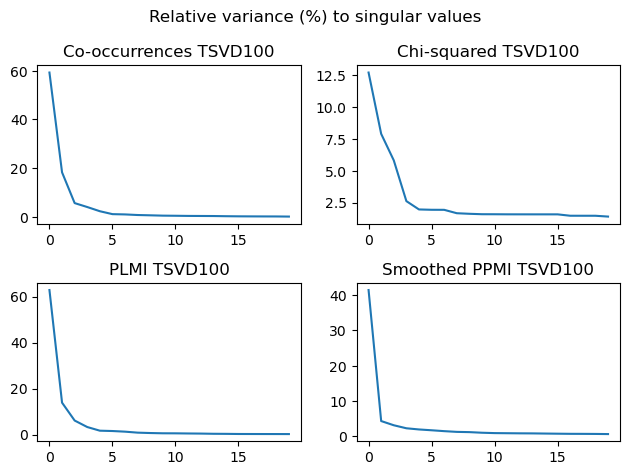

In [9]:
# finding optimal number of dimensions

measure_to_svd = {"Co-occurrences TSVD100" : surface_co_tsvd100,
                  "Chi-squared TSVD100" : chisq_tsvd100,
                 "PLMI TSVD100" : plmi_tsvd100,
                 "Smoothed PPMI TSVD100" : sppmi_tsvd100}

fig, axes = plt.subplots(2, 2)

for i, (measure, svd) in enumerate(measure_to_svd.items()):
    S_sq = svd.singular_values_ ** 2
    explained_var = (S_sq / sum(S_sq)) * 100
    y = explained_var[:20]
    x = np.arange(len(y))

    axes[i // 2][i % 2].plot(x, y, ls = '-')
    axes[i // 2][i % 2].set_title(measure)

fig.suptitle("Relative variance (%) to singular values")
fig.tight_layout()
plt.show()

In [10]:
# using new values for dimensions based on
# the inflection points in scree plot

surface_co_tsvdopt_mat = TSVD(n_components = 4, algorithm = "arpack").fit_transform(surface_co_mat)
chisq_tsvdopt_mat = TSVD(n_components = 5, algorithm = "arpack").fit_transform(chisq_mat)
plmi_tsvdopt_mat = TSVD(n_components = 4, algorithm = "arpack").fit_transform(plmi_mat)
sppmi_tsvdopt_mat = TSVD(n_components = 3, algorithm = "arpack").fit_transform(sppmi_mat)

<h3> EXPLANATION </h3>

mention here reasoning for splitting TSVD().fit_transform() into two lines
when you have the time also do it for the surface co-occurrences

## Question 4 (15 points)

Train a Word2Vec model on the same corpus, for example using [gensim](https://radimrehurek.com/gensim). Make sure to motivate the choice of your hyperparameters.

**Possible extra**

*Hyperparameter tuning* is the process of finding the optimal hyperparameters in a machine learning task for a given task and data set. Try performing some kind of hyperparameter tuning on your Word2Vec model. Hint: Do this after question 5, so that you'll have a way to know what hyperparameter combination is best.

In [11]:
# your code here

from gensim.models import Word2Vec

params = {
    'vector_size': 20, # dimensions
    'window': 5,
    'epochs': 5,
    'min_count': 10, # same as surface co-occurrences
    'sg': 0, # not the skip-gram (1), use CBOW (0)
    'negative': 5,
    'workers': 4, # how many cores to use
    'alpha': 0.05 # learning rate
}

cbow_model = Word2Vec(reuters_le, **params)
print(cbow_model)

Word2Vec<vocab=7336, vector_size=20, alpha=0.05>


<h3> EXPLANATION </h3>

urm

hi

---

# Evaluating on semantic similarity (17 points)

## Question 5 (17 points)

Evaluate the performance of your models on a **semantic similarity task**. Using `SimLex-999` as gold standard. Evaluate all of your models on the dataset in `data/SimLex-999.txt`, and determine the best performing model. Note: There should be 5 to 8 model evaluations in total. 5 if you did not do any extra (2 from Q2 + 2 from Q3 + 1 from Q4), and 8 if you did them all (1 from Q1, 3 from Q2 + 3 from Q3 + 2 from Q4).

1. Your evaluation should follow the approach shown in lab 4 (Section 1.6: "Evaluating your Model"), using a **correlation measure** on model predictions and the (human) gold standard. 
2. Remember to **visualize** your results (e.g., as bar plots).
3. Take note (and report) the overlap between your models and the SimLex-999 dataset, i.e., how many pairs are shared by your model and the evaluation dataset.
4. Make sure to discuss your results and provide your reasoning on them.

### Remarks

- The 'SimLex-999' dataset is described in `data/SimLex-999.README.txt`, and [the author's github page](https://fh295.github.io/simlex.html). Hint: the relevant judgements are those in the `SimLex999` column.
- To directly compare the models against the gold standard, you will have to find the *overlap* between them, i.e. the pairs that occur in your model *and* the evaluation dataset.

In [12]:
# defining the similarity matrices

surface_co_tsvd100_simmat = cosine_similarity(surface_co_tsvd100_mat)
chisq_tsvd100_simmat = cosine_similarity(chisq_tsvd100_mat)
plmi_tsvd100_simmat = cosine_similarity(plmi_tsvd100_mat)
sppmi_tsvd100_simmat = cosine_similarity(sppmi_tsvd100_mat)

surface_co_tsvdopt_simmat = cosine_similarity(surface_co_tsvdopt_mat)
chisq_tsvdopt_simmat = cosine_similarity(chisq_tsvdopt_mat)
plmi_tsvdopt_simmat = cosine_similarity(plmi_tsvdopt_mat)
sppmi_tsvdopt_simmat = cosine_similarity(sppmi_tsvdopt_mat)

# cbow_model.wv.similarity(w1, w2)

In [13]:
with open("data/SimLex-999.txt") as f:
    for n, line in enumerate(f.read().split("\n")):
        items = line.split("\t")

        # we look at SimLex999 scores, the fourth column
        break

In [14]:
# your code here

---